In [2]:
# A single-file scripts for synthetic data set generating and method running 
import pandas as pd
import numpy as np
import cv2 as cv
import glob
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
from PIL import Image, ImageOps
import cv2
import imgaug as ia
from imgaug import augmenters as iaa
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset
import sys
import torch.optim as optim
import math
sys.path.append(".")



In [9]:
mean = (16, 64) #settings for the multivariate Gaussian distribution---------------------------------
cov = [[1, 0], [0, 1]]
cov = np.array([[12, 40], [40, 300]])
pts = np.random.multivariate_normal(mean, cov, size=8000)

In [10]:
pts.mean(axis=0)

array([16.06587839, 64.25748004])

In [11]:
np.cov(pts.T)

array([[ 12.06099013,  40.7625571 ],
       [ 40.7625571 , 302.05501363]])

In [31]:
print(np.corrcoef(pts.T)[0, 1])
print(np.sqrt(1-np.corrcoef(pts.T)[0, 1]*np.corrcoef(pts.T)[0, 1]))

0.6753469063020807
0.7375002075580783


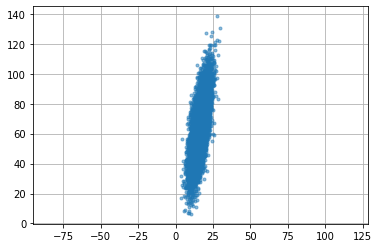

In [13]:
plt.plot(pts[:, 0], pts[:, 1], '.', alpha=0.5)
plt.axis('equal')
plt.grid()
plt.show()

In [14]:
print(np.min(pts[:, 0]), np.max(pts[:, 0]))
print(np.min(pts[:, 1]), np.max(pts[:, 1]))

3.6336431874363804 29.90794375009262
6.356016847085378 138.46343149228818


In [15]:
min_col = np.min(pts[:, 1])
max_col = np.max(pts[:, 1])

Folder 'circle_dataset/' already exists.


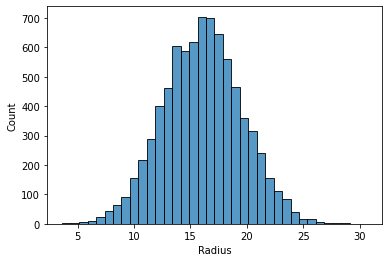

In [32]:
# now start the image generation-----------------------------------------------
n = 8000  # to generate 8000 images
size_img = 63 #image size 63x63
r_ball = 1

r_ball_list, col_list = [],[]

if not os.path.exists('circle_dataset/'):
    os.makedirs('circle_dataset/')
    print(f"Folder '{'circle_dataset/'}' created successfully.")
else:
    print(f"Folder '{'circle_dataset/'}' already exists.")

    
for i in range(n):
    #if i> 5:
    #    break
    temp_img = np.zeros([size_img,size_img])
    r_ball = pts[i,0]
    col_index = pts[i,1]
    if col_index < 0:
        col_index = 0
    col_index = int(col_index)
    col_list = np.append(col_list,col_index)
    r_ball_list = np.append(r_ball_list,r_ball)
    for ix in range(size_img):
        for iy in range(size_img):
            dist = np.sqrt((ix-31)*(ix-31)+(iy-31)*(iy-31))
            if dist < r_ball:
                temp_img[ix,iy]=255-col_index
    cv.imwrite('circle_dataset/'+str(i)+'_'+str(r_ball.squeeze(0))+'_'+str(col_index)+'.png',temp_img) #write the image as files
df = pd.DataFrame({'Radius':r_ball_list, 'Brightness':1-(col_list-min_col)/(max_col-min_col)}) #convert gray scale to brightness 0-1

#now double check the characteristic of the data set
fig = plt.figure()
sns.histplot(df['Radius'],  bins=range(0, 255), binwidth=0.75,label="0") #check the distribution of 'Radius'
fig.savefig('histogram_radius.svg', format='svg', dpi=1200,bbox_inches="tight")

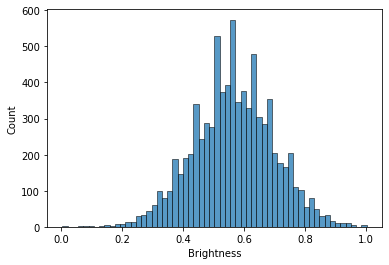

In [33]:
fig = plt.figure() #check the distribution of 'brightness'
sns.histplot(df['Brightness'] )
fig.savefig('histogram_brightness.svg', format='svg', dpi=1200,bbox_inches="tight")

<Figure size 432x288 with 0 Axes>

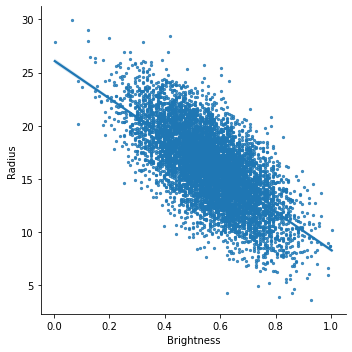

In [34]:
fig = plt.figure() #check the joint distribution
fig=sns.lmplot(x='Brightness',y='Radius',data=df,scatter_kws={"s": 5})
fig.savefig('joint_distribution.svg', format='svg', dpi=1200,bbox_inches="tight")


In [35]:
# define the autoencoder model------------------------------------


class Encoder(nn.Module):
    def __init__(self, nc, nef, nz, isize, device):
        super(Encoder, self).__init__()

        # Device
        self.device = device

        # Encoder: (nc, isize, isize) -> (nef*8, isize//16, isize//16)
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, nef, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef),

            nn.Conv2d(nef, nef*2, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*2),

            nn.Conv2d(nef*2, nef*4, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*4),

            nn.Conv2d(nef*4, nef*8, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*8)
        )

        # Map the encoded feature map to the latent vector of mean, (log)variance
        out_size = isize // 16
        self.mean = nn.Linear(nef*8*out_size*out_size, nz)
        self.logvar = nn.Linear(nef*8*out_size*out_size, nz)

    def reparametrize(self, mean, logvar):
        std = logvar.mul(0.5).exp_()
        multi_norm = torch.FloatTensor(std.size()).normal_().to(self.device)
        multi_norm = Variable(multi_norm)
        return multi_norm.mul(std).add_(mean)

    def forward(self, inputs):
        # Batch size
        batch_size = inputs.size(0)
        # Encoded feature map
        hidden = self.encoder(inputs)
        # Reshape
        hidden = hidden.view(batch_size, -1)
        # Calculate mean and (log)variance
        mean, logvar = self.mean(hidden), self.logvar(hidden)
        # Sample
        latent_z = self.reparametrize(mean, logvar)
        #latent_z = mean
        return latent_z, mean, logvar

class Decoder(nn.Module):
    def __init__(self, nc, ndf, nz, isize):
        super(Decoder, self).__init__()

        # Map the latent vector to the feature map space
        self.ndf = ndf
        self.out_size = isize // 16
        self.decoder_dense = nn.Sequential(
            nn.Linear(nz, ndf*8*self.out_size*self.out_size),
            nn.ReLU(True)
        )
        # Decoder: (ndf*8, isize//16, isize//16) -> (nc, isize, isize)
        self.decoder_conv = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*8, ndf*4, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf*4, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*4, ndf*2, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf*2, 1.e-3),
        
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*2, ndf, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf, nc, 3, padding=1),
            nn.ReLU(True)
        )

    def forward(self, input):
        batch_size = input.size(0)
        hidden = self.decoder_dense(input).view(
            batch_size, self.ndf*8, self.out_size, self.out_size)
        output = self.decoder_conv(hidden)
        return output

class VAE(nn.Module):
    def __init__(self, nc=1, ndf=4, nef=4, nz=2, isize=64, device=torch.device("cuda:0"), is_train=True):
        super(VAE, self).__init__()

        self.nz = nz
        # Encoder
        self.encoder = Encoder(nc=nc, nef=nef, nz=nz, isize=isize, device=device)
        # Decoder
        self.decoder = Decoder(nc=nc, ndf=ndf, nz=nz, isize=isize)
        self.pe = nn.Linear(nz, 1, bias=False)
        if is_train == False:
            for param in self.encoder.parameters():
                param.requires_grad = False
            for param in self.decoder.parameters():
                param.requires_grad = False

    def forward(self, x):
        latent_z, mean, logvar = self.encoder(x)
        rec_x = self.decoder(latent_z)
        zp = self.pe(latent_z)

        return rec_x, mean, logvar, latent_z, zp
    
    def encode(self, x):
        latent_z, _, _ = self.encoder(x)
        return latent_z

    def decode(self, z):
        return self.decoder(z)

In [36]:
#loss functions---------------------------------

def torch_corr(input1, input2, device):  #The correlation loss function

    mean_1 = torch.mean(input1)
    mean_2 = torch.mean(input2)
    var_1 = torch.var(input1)
    var_2 = torch.var(input2)
    vector_mean1 = mean_1*torch.ones([len(input1)]).to(device)
    vector_mean2 = mean_2*torch.ones([len(input2)]).to(device)
    #print(input2, vector_mean2)
    diff_1 = input1 - vector_mean1
    diff_2 = input2 - vector_mean2

    exp = torch.mul(diff_1,diff_2)
    exp = torch.sum(exp)   


    exp = exp / len(input1)
    exp = exp / torch.sqrt(var_1*var_2)
    return abs(exp)


class KLDLoss(nn.Module):
    def __init__(self, reduction='sum'):
        super(KLDLoss, self).__init__()
        self.reduction = reduction

    def forward(self, mean, logvar):
        # KLD loss
        kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), 1)
        # Size average
        if self.reduction == 'mean':
            kld_loss = torch.mean(kld_loss)
        elif self.reduction == 'sum':
            kld_loss = torch.sum(kld_loss)
        return kld_loss

In [37]:
# data loader----------------------------------


class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Sometimes(0.4,\
            iaa.ContrastNormalization((0.8, 1.2), per_channel=0.5)),
        iaa.Sometimes(0.4,\
            iaa.GaussianBlur(sigma=(0, 0.2))),
    ])
      
  def __call__(self, img):
    img = np.array(img)
    img = self.aug.augment_image(img)
    return img

class ImageDataset(Dataset):
    def __init__(self, paths_image,is_aug=False):
        super(ImageDataset, self).__init__()

        # Length
        self.length = len(paths_image)
        # Image path
        self.paths_image = paths_image

        # Augment
        self.is_aug = is_aug
        self.transform = transforms.Compose([
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            ImgAugTransform(),
            lambda x: Image.fromarray(x),
        ])
        # Preprocess
        self.output = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            ])

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Image
        #print(idx)
        img = Image.open(self.paths_image[idx].replace('\n',''))
        img = self.output(img)
        file_name = self.paths_image[idx].replace('\n','')
        id_name = file_name.split('/')
        id_name = id_name[len(id_name)-1].replace('.png','')
        split_file_name = file_name.split('_')
        len_split = len(split_file_name)
        color = split_file_name[len_split-1].replace('.png','')
        number = split_file_name[len_split-2]
        return img, float(number) ,1-( float(color)-min_col)/(max_col-min_col), str(id_name) #convert gray scaleto brightness (0-1)

    
data_path = 'circle_dataset/'
dir_or_files = os.listdir(data_path)
table_all = []
dental_list = []
f = open('all_data_list.txt','w')
for dir_file in dir_or_files:
    f.write(data_path+dir_file)
    f.write('\n')

#print(table_all)
f.close()


# this dataloader was implemented with class 'ImageDataset' for dynamic memory control
def get_celeba_loaders(batch_train, batch_test):
    test_num = 2000 # first test_num samples for validation
    f = open('all_data_list.txt','r')      # paths for input
    file_list = f.readlines()
    #print(len(file_list))
    datasets = {
        "train":  ImageDataset(file_list[test_num:],True),
        "test": ImageDataset(file_list[:test_num], False)
    }


    dataloaders = {
        "train": DataLoader(  datasets["train"],  batch_size=batch_train, shuffle=True),
        "test": DataLoader( datasets["test"], batch_size=batch_test, shuffle=False)
    }
    return dataloaders




In [38]:
# display functions--------------------------


if "DISPLAY" not in os.environ:
    plt.switch_backend("Agg")

def plot_loss(dirname, history):
    """ Plot loss """

    plot_train = np.array(history["train"])
    is_val = ("test" in history.keys())
    if is_val:
        plot_val = np.array(history["test"])

    if not os.path.exists(dirname):
        os.makedirs(dirname)

    # epochs
    n_epochs = len(plot_train)

    # X axis
    x = [i for i in range(1, n_epochs+1)]
    
    # plot loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.xlabel('epoch')
    plt.plot(x, plot_train[:], label='train loss')
    if is_val:
        plt.plot(x, plot_val[:], label='test loss')

    plt.legend()
    plt.savefig(os.path.join(dirname,'loss.png'))
    plt.close()

def imsave(x, rec_x, path, row=2, col=2):
    """ Save the first row*col images """
    #print(x.size())
    #exit(0)
    # Save dir
    save_dir = os.path.dirname(path)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # To cpu, numpy, uint8 format and (num, h, w, c) shape
    in_imgs = (x.clone().cpu().detach().numpy()[:row*col]*255)\
        .astype(np.uint8).transpose(0, 2, 3, 1)[:, :, :, ::-1]
    out_imgs = (rec_x.clone().cpu().detach().numpy()[:row*col]*255)\
        .astype(np.uint8).transpose(0, 2, 3, 1)[:, :, :, ::-1]

    # Reshape
    in_imgs = cv2.vconcat([cv2.hconcat([in_imgs[i+j] for j in range(0, col)])
        for i in range(0, row*col, col)])
    out_imgs = cv2.vconcat([cv2.hconcat([out_imgs[i+j] for j in range(0, col)])
        for i in range(0, row*col, col)])
   # print(in_imgs.shape)
    #exit(0)
    # Concat
    h, _,  = in_imgs.shape
    margin_shape = (h, 5 )
    margin = np.ones(margin_shape, np.uint8) * 255
    concat_imgs = cv2.hconcat([in_imgs, margin, out_imgs])

    # Save
    cv2.imwrite(path, concat_imgs)

def imsave_inp(x, path, row=1, col=11):
    """ Save the interpolated images """

    # Save dir
    save_dir = os.path.dirname(path)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # To cpu, numpy, uint8 format and (num, h, w, c) shape
    in_imgs = (x.clone().cpu().detach().numpy()[:row*col]*255)\
        .astype(np.uint8).transpose(0, 2, 3, 1)[:, :, :, ::-1]

    # Reshape
    in_imgs = cv2.vconcat([cv2.hconcat([in_imgs[i+j] for j in range(0, col)])
        for i in range(0, row*col, col)])

    # Save
    cv2.imwrite(path, in_imgs)

class Logger:
    def __init__(self, path):
        self.f = open(path, 'w')

    def __del__(self):
        self.f.close()

    def write(self, text):
        self.f.write(text+"\n")
        self.f.flush()
        print(text)

In [49]:
# training------------------------

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs=100
batch_train = 16
batch_test = 64
eta = 2.0 ## see Eq. 3 in the paper     if eta==0, then disable confounder correction
lambda_par=1000 # see Eq. 5 in the paper
# Dataloader
dataloaders = get_celeba_loaders(batch_train, batch_test) # train batch size : 16;  test batch size: 64
# Model
model = VAE(device=device).to(device)


reconst_criterion = nn.MSELoss(reduction='sum')

kld_criterion = KLDLoss(reduction='sum')

# Solver
optimizer = optim.Adam(model.parameters(), lr=0.005)
# Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.97, last_epoch=-1)

#----model lr, see t^=LR(zp) in the manuscript

model_lr = torch.nn.Linear(1,1).to(device)
optimizer_lr = optim.Adam(model_lr.parameters(), lr=0.05)
scheduler_lr = optim.lr_scheduler.StepLR(optimizer_lr, 1, gamma=0.97, last_epoch=-1)
#----
# Log
logdir = './log/pvae'

if not os.path.exists(logdir):
    os.makedirs(logdir)
# Logger
logger = Logger(os.path.join(logdir, "log.txt"))
# History
history = {"train": [], "test": []}


# Start training
for epoch in range(epochs):
    num_list, col_list, zp_list, cp_list,tp_list,zp2_list,logit_out_list = [],[],[],[],[],[],[]
    mse_loss_total = 0
    for phase in ["train", "test"]:
        if phase == "train":
            model.train(True)
            model_lr.train(True)
            logger.write(f"\n----- Epoch {epoch+1} -----")
        else:
            model.train(False)
            model_lr.train(False)
        # Loss
        running_loss = 0.0
        # Data num
        data_num = 0

        i = 0
        i_test = 0
        for data in dataloaders[phase]:
            x = data[0].to(device)
            num_t = data[1].to(device) #radius
            col_t = data[2].to(device) #brightness
            id_name = data[3]

            #print(num_t, col_t,id_name)
            #exit(0)
            # Optimize params

            if phase == "train":
                optimizer.zero_grad()
                if len(num_t) != batch_train:
                    continue
                # Pass forward
                x = x.to(device)
                rec_x, mean, logvar, latent_z , zp  = model(x)
                # Calc loss
                zp = zp.view([len(num_t)])
                corr_loss = - torch_corr(zp, col_t,device) + eta*torch_corr(zp, num_t, device)
                reconst_loss =  reconst_criterion(rec_x, x)
                kld_loss = kld_criterion(mean, logvar)
                loss =  lambda_par*corr_loss+  reconst_loss +  kld_loss
                loss.backward()
                optimizer.step()
                #-------finish the update of the proposed AI model

                optimizer_lr.zero_grad()
                rec_x, _, _, _ , zp= model(x)
                #print(zp.size())
                logit_out = model_lr(zp)
                logit_out = logit_out.view([len(logit_out)])
                #print(logit_out.size(), col_t.size())
                loss_lr = F.mse_loss(logit_out.float(), col_t.float(),reduction='mean')
                loss_lr.backward()
                optimizer.zero_grad()
                optimizer_lr.step()
                # ------------------------finish the update of the LR model
                x[x<0]=0
                rec_x[rec_x<0]=0
                x[x>1]=1
                rec_x[rec_x>1]=1
                # Visualize
                if i == 0 and x.size(0) >= batch_train:
                    imsave(x, rec_x, os.path.join(logdir, f"epoch{epoch+1}", f"train.png"), 2, 4)
    
            elif phase == "test":
                with torch.no_grad():
                    optimizer.zero_grad()
                    # Pass forward
                    x = x.to(device)
                    rec_x, mean, logvar, latent_z, zp= model(x)
                    logit_out = model_lr(zp)
                    zp = zp.view([len(num_t)])
                    logit_out = logit_out.view([len(num_t)])
                    #print(logit_out.size(), col_t.size())
                    loss_lr_test = F.mse_loss(logit_out.float(), col_t.float(),reduction='mean')
                    num_list = np.append(num_list, num_t.cpu().numpy())
                    logit_out_list = np.append(logit_out_list, logit_out.cpu().numpy())
                    col_list = np.append(col_list, col_t.cpu().numpy())
                    zp_list = np.append(zp_list, zp.cpu().numpy())
                    # Calc loss
                    mse_loss_total = mse_loss_total +loss_lr_test.item()
                    diy_l1loss = nn.L1Loss(reduction='mean')
                    loss = diy_l1loss(rec_x, x)  #L1 loss for Table 1 in the manuscript
                    x[x<0]=0
                    rec_x[rec_x<0]=0
                    x[x>1]=1
                    rec_x[rec_x>1]=1
                    if i_test == 0 and x.size(0) >= 16:
                        imsave(x, rec_x, os.path.join(logdir, f"epoch{epoch+1}", f"test-{i}.png"), 8, 8)
                        i_test = i_test + 1

            i = i + 1
            # Add stats

            running_loss += loss  #* x.size(0)
            data_num +=1

        # Log

        epoch_loss = running_loss / data_num
        history[phase].append(epoch_loss)
        if phase == "test":
            logger.write(f"{phase} L1-Loss : {epoch_loss:.4f}")        

        #if phase == "test":
        #    plot_loss(logdir, history)
#-----
    mse_loss_total = mse_loss_total/len(dataloaders["test"])
    #print('data_num:, len_dataloader:', data_num, len(dataloaders["test"]))
    scheduler.step()
    scheduler_lr.step()
    tp_list=np.array(tp_list)
    cp_list=np.array(cp_list)
    zp_list=np.array(zp_list)
    #zp2_list=np.array(zp2_list)
    col_list=np.array(col_list)
    num_list=np.array(num_list)

    corr_loss_num = np.corrcoef(zp_list, num_list)[0,1]   #the correlation coefficient in the test set should be global-population-level, instead of batch-level
    corr_loss_col = np.corrcoef(zp_list, col_list)[0,1]

    print('corr_radius, corr_brightness in test set:', corr_loss_num,corr_loss_col)
    print('r-mse_loss of brightness in test set:',np.sqrt(mse_loss_total)) 
    #print('corr_num2, corr_col2', corr_loss_num2,corr_loss_col2)
    #torch.save(model.state_dict(),\
    #    os.path.join(logdir, 'final_model'+str(epoch)+'.pth'))




----- Epoch 1 -----
test L1-Loss : 0.0438
corr_radius, corr_brightness in test set: 0.7007519383040751 -0.8133629874949845
r-mse_loss of brightness in test set: 0.1494249397569561

----- Epoch 2 -----
test L1-Loss : 0.0254
corr_radius, corr_brightness in test set: 0.08898947248610722 -0.7424482055085755
r-mse_loss of brightness in test set: 0.1191126494267125

----- Epoch 3 -----
test L1-Loss : 0.0246
corr_radius, corr_brightness in test set: 0.00013344766272323455 -0.6633377376776991
r-mse_loss of brightness in test set: 0.14033117379080542

----- Epoch 4 -----
test L1-Loss : 0.0153
corr_radius, corr_brightness in test set: 0.14287941775872254 -0.687655562802699
r-mse_loss of brightness in test set: 0.10894132482969568

----- Epoch 5 -----
test L1-Loss : 0.0118
corr_radius, corr_brightness in test set: 0.1635396737060683 -0.7853336077468472
r-mse_loss of brightness in test set: 0.08401857265673796

----- Epoch 6 -----
test L1-Loss : 0.0119
corr_radius, corr_brightness in test set: 0.

test L1-Loss : 0.0058
corr_radius, corr_brightness in test set: 0.027319108070875783 -0.7392590321295024
r-mse_loss of brightness in test set: 0.09022865719491187

----- Epoch 47 -----
test L1-Loss : 0.0057
corr_radius, corr_brightness in test set: -0.07113153004202429 -0.6697086642636173
r-mse_loss of brightness in test set: 0.09975745785198525

----- Epoch 48 -----
test L1-Loss : 0.0062
corr_radius, corr_brightness in test set: -0.02753143911038495 -0.7027154035150861
r-mse_loss of brightness in test set: 0.09661847175995752

----- Epoch 49 -----
test L1-Loss : 0.0054
corr_radius, corr_brightness in test set: -0.016321734714220743 -0.71077017140695
r-mse_loss of brightness in test set: 0.09610850501768027

----- Epoch 50 -----
test L1-Loss : 0.0059
corr_radius, corr_brightness in test set: 0.04840922662322747 -0.7519582377248992
r-mse_loss of brightness in test set: 0.09030490214947778

----- Epoch 51 -----
test L1-Loss : 0.0049
corr_radius, corr_brightness in test set: 0.02176066760

test L1-Loss : 0.0056
corr_radius, corr_brightness in test set: -0.019221691404758403 -0.7112737278109279
r-mse_loss of brightness in test set: 0.0975727502162091

----- Epoch 92 -----
test L1-Loss : 0.0043
corr_radius, corr_brightness in test set: 0.07284022266974498 -0.7724523251213237
r-mse_loss of brightness in test set: 0.08657864487207104

----- Epoch 93 -----
test L1-Loss : 0.0046
corr_radius, corr_brightness in test set: -0.005354038961984298 -0.7211310709844737
r-mse_loss of brightness in test set: 0.09414722683618562

----- Epoch 94 -----
test L1-Loss : 0.0053
corr_radius, corr_brightness in test set: 0.16928927727562784 -0.8299456372280352
r-mse_loss of brightness in test set: 0.07738450456499504

----- Epoch 95 -----
test L1-Loss : 0.0044
corr_radius, corr_brightness in test set: 0.03572461696231881 -0.7491664432072549
r-mse_loss of brightness in test set: 0.0890315718741708

----- Epoch 96 -----
test L1-Loss : 0.0055
corr_radius, corr_brightness in test set: -0.03905014754

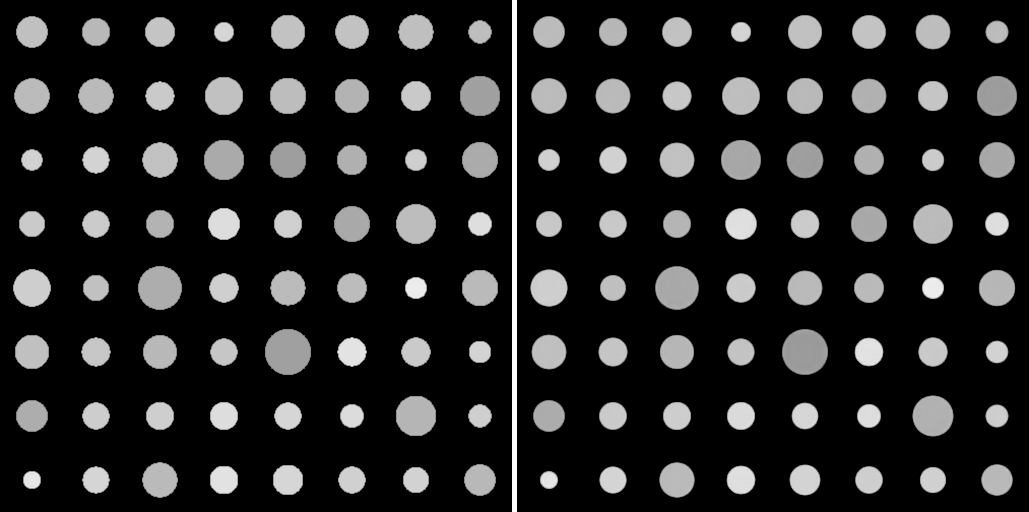

In [50]:
# first check the reconstruction images.  left: input ;   right: reconstruction
image = Image.open('./log/pvae/epoch100/test-0.png')
display(image)

Parameter containing:
tensor([[1.3525, 0.0548]], device='cuda:0', requires_grad=True)
mean-3*SD, mean+3*SD: 0.8354225158691406 0.26559025049209595
brightness frame: 1 0.8350263237953186
brightness frame: 2 0.7781223654747009
brightness frame: 3 0.7212183475494385
brightness frame: 4 0.6643143892288208
brightness frame: 5 0.6074103713035583
brightness frame: 6 0.5505064129829407
brightness frame: 7 0.4936023950576782
brightness frame: 8 0.43669840693473816
brightness frame: 9 0.3797944188117981
brightness frame: 10 0.32289040088653564
brightness frame: 11 0.26598644256591797
(11, 2)
(2000, 2)
(2000, 2)


<Figure size 1080x648 with 0 Axes>

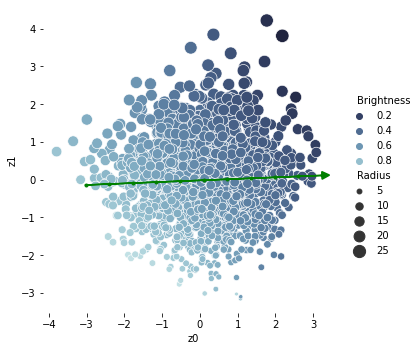

In [51]:

#---------------- plot the latent space and vector p*
dataloaders = get_celeba_loaders(1, 1)
with torch.no_grad():
    model.train(False)
    print(model.pe.weight)
    #exit(0)
    z_list, zp_list, num_list, col_list = [], [], [], []
    for data in dataloaders["test"]:
        x = data[0]
        x = x.to(device)
        num_t = data[1].to(device)
        col_t = data[2].to(device)
        rec_x, _, _, latent_z , zp= model(x)
        z_list.append(latent_z.unsqueeze(1))
        zp_list.append(zp.unsqueeze(1))
        num_list.append(num_t.unsqueeze(0))
        col_list.append(col_t.unsqueeze(0))

    z_list_tensor = torch.cat(z_list).squeeze(1)
    zp_list_tensor = torch.cat(zp_list).squeeze(1)
    zp_list_tensor = zp_list_tensor.squeeze(1)


    num_list_tensor = torch.cat(num_list).squeeze(1)
    col_list_tensor = torch.cat(col_list).squeeze(1)
    #exit(0)
    z_mean = torch.mean(z_list_tensor,dim=0)
    zp_mean = torch.mean(zp_list_tensor,dim=0)
    zp_std = torch.std(zp_list_tensor, dim=0)
    z_project_max,_ = torch.max(zp_list_tensor,dim=0)
    z_project_min,_ = torch.min(zp_list_tensor,dim=0)
    print('mean-3*SD, mean+3*SD:',model_lr((zp_mean-3*zp_std).unsqueeze(0)).item(), model_lr((zp_mean+3*zp_std).unsqueeze(0)).item())
    rec_tensors = torch.zeros((11,1, 64, 64))
    z_mean = z_mean.unsqueeze(0)


    flag_sampling = 1
    par_amp = 0.03
    loop_count = 0
    while flag_sampling and loop_count < 10000:      # control the sampling range to be mean+-3*SD
        loop_count = loop_count + 1
        middle_left = z_mean + par_amp*(0-5) * model.pe.weight  
        middle_right = z_mean + par_amp*(10-5) * model.pe.weight  
        middle_project_left = model.pe(middle_left)
        middle_project_right = model.pe(middle_right)
        #print(middle_project_right)
        tmp_max = torch.maximum(middle_project_left, middle_project_right)
        if torch.abs(tmp_max - (zp_mean+3*zp_std)) < 0.01:
            break
        if tmp_max - (zp_mean+3*zp_std) > 0:
            par_amp = par_amp - 0.001 
        else:
            par_amp = par_amp + 0.001

    
    points_list = []  # now start the sampling along vector p*
    for i in range(11): 
        middle = z_mean + (i-5) * model.pe.weight*par_amp 
        middle_project = model.pe(middle)
        logit_out = model_lr(middle_project)
        points_list.append(middle)
        print('brightness frame:',i+1, logit_out.item())
        rec_tensors[i] = model.decode(middle)
        rec_tensors[rec_tensors<0]=0
        rec_tensors[rec_tensors>1]=1
        imsave_inp(rec_tensors, os.path.join(logdir, f"{'frame'}-{i+1}.png"))


    #plot the datapoints in the latent space, together with the vector p*
    points_list = torch.cat(points_list)
    points_list = points_list.cpu().numpy()
    print(points_list.shape)

    latent_all= np.array(z_list_tensor.cpu().numpy())
    latent_all = latent_all.reshape((-1,2))
    print(latent_all.shape)

    #exit(0)
    z_list_numpy = z_list_tensor.cpu().numpy()
    num_list = num_list_tensor.cpu().numpy()
    col_list = col_list_tensor.cpu().numpy()
    print(z_list_numpy.shape)
    data_df = pd.DataFrame({ 'z0':z_list_numpy[:,0],'z1':z_list_numpy[:,1],'Brightness':col_list, 'Radius':num_list})

    plt.figure(figsize=(15,9))
    cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True,reverse=True)
    g = sns.relplot(
        #alpha=0.7,
        data=data_df,
        x="z0", y="z1",
        hue="Brightness", size="Radius",
        palette = cmap, sizes=(15, 180),
        #palette = "gist_gray_r", sizes=(2, 100),
    )

    #exit(0)
    #g.set(xscale="log", yscale="log")
    line_pe = model.pe.weight.cpu().numpy()
    point1 = [points_list[0,0],points_list[0,1]]
    point2 = [points_list[10,0],points_list[10,1]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
#    plt.plot(x_values, y_values, 'go', linestyle="--")
    #g.ax.xaxis.grid(True, "minor", linewidth=.25)
    #g.ax.yaxis.grid(True, "minor", linewidth=.25)
    plt.plot(points_list[:,0], points_list[:,1], '.', color='green');
    plt.arrow(points_list[0,0],points_list[0,1],points_list[10,0] - points_list[0,0],points_list[10,1]-points_list[0,1], head_width=0.2, head_length=0.2, linewidth=1.5, color='g', length_includes_head=False)
    plt.axis('scaled')
    g.despine(left=True, bottom=True)
    plt.show()


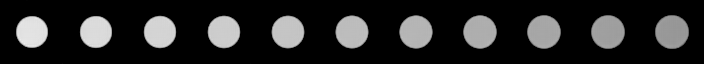

In [52]:
image = Image.open(os.path.join(logdir, f"{'frame'}-{11}.png")) # plot the 11 frames reconstructed images along vector p*
display(image)

In [ ]:
#result of exp 3.1, with confounder control